# Simulate acoustic wave propagation on a sphere with user-defined material properties


The OptimUS library provides functionality to simulate acoustic wave propagation in unbounded domains with homogeneous scatterers. This notebook showcases the basic functionality to perform acoustic simulations. The simulation consists of an incident plane wave in an unbounded water region and a spherical scatterer resembling bone.


## Import the OptimUS library

Load the OptimUS library. Make sure the source code is in the Python path.

In [1]:
# Make sure the OptimUS library is in the Python path.
import sys
sys.path.append('..')

In [2]:
import optimus

In [3]:
print("OptimUS version:", optimus.__version__)

OptimUS version: 0.0.0


## Specify the physical settings for the simulation

The OptimUS library provides functionality to simulate acoustic wave propagation. For each simulation, one needs to specify the type of source of the acoustic field, the geometry of the scatterer, and the material parameters.

The OptimUS library provides different predefined wave fields, among which a plane wave. The plane wave requires the frequency to be specified and, optionally, the wave direction.

In [4]:
frequency = 1000
source = optimus.source.create_planewave(frequency)

Several canonical shapes for scatterers are available in the OptimUS library. Let us use a spherical geometry, by default centered at the origin and unit radius. It is recommended to specify the meshwidth of the triangular surface grid that represents the geometry's surface. A lower value of `element_size` increases the precision of the algorithm but also the computational costs.

In [5]:
geometry = optimus.geometry.shapes.Sphere(element_size=0.4)

To see the table of material database and pick the correct tissue name use:

In [6]:
materials_table = optimus.material.common.get_excel_database(database='default')

In [7]:
materials_table.style.set_properties(**{'border': '1.3px solid green','color': 'blue'})

The exterior medium will be fat and the interior medium a user-defined material with specific values for density and wavespeed. 

In [8]:
material_ext = optimus.material.load_material('FaT')

In the case of multiple domains, a list of materials should be passed to the load_material function above. Input to the load_material function, i.e. the name of materials, is case insensitive. 

To define a new material, the user can pass the material properties as the function input arguments or a dictionary, with the keys identical to the arguments. Currently, the following properties are only needed for calculations, thus other parameters can be skipped for now. The required parameters are: name (string), density (float), speed of sound (float), attenuation_coeff_a (float), attenuation_pow_b (float). The units are SI, as shown in the table above. 

In [9]:
material_user_1 = optimus.material.create_material(name='new-material-test',
                                                   density=2500,
                                                   speed_of_sound=1500)

let's print the material properties (the default value for unassigned parameters are zero)

In [10]:
material_user_1.print()

              name  density  speed_of_sound  attenuation_coeff_a  attenuation_pow_b
 new-material-test   2500.0          1500.0                  0.0                0.0


In [11]:
properties = {
    "name": 'new-material',
    "density": 2000,
    "speed_of_sound": 4000,
    "attenuation_coeff_a": 50,
    "attenuation_pow_b": 1.5,
}

In [12]:
material_user_2 = optimus.material.create_material(**properties)

In [13]:
material_user_2.print()

         name  density  speed_of_sound  attenuation_coeff_a  attenuation_pow_b
 new-material   2000.0          4000.0                 50.0                1.5


the user-defined materials can be written into an excel file by setting the save_to_file argument to True (default is False) and can be recalled in the future use, as follows: 

```python
optimus.material.create_material(**properties,save_to_file=True)
```
Note: if a material with identical name already exists in the database files, the code raises an error.

In [14]:
user_mat = optimus.material.load_material('new-material')

In [15]:
user_mat.print()

         name  density  speed_of_sound  attenuation_coeff_a  attenuation_pow_b
 new-material   2000.0          4000.0                 50.0                1.5


In [16]:
optimus.material.common.get_excel_database(database='user-defined',index_col=0)

Attenuation Constant      Density (kg/m3) Heat Capacity (J/kg/°C)  \
          a [Np/m/MHz]    b         Average                 Average   
0                   50  1.5            2000                     NaN   

  Heat Generation Rate (W/kg) Heat Transfer Rate (ml/min/kg)  \
                      Average                        Average   
0                         NaN                            NaN   

  Nonlinearity Prameter B/A Speed of Sound [m/s]  \
                    Average              Average   
0                       NaN                 4000   

  Thermal Conductivity (W/m/°C)        Tissue  
                        Average          Name  
0                           NaN  new-material

We will use this user-defined material for the interior of the sphere.

In [17]:
material_int = material_user_2

## Simulate the wave model

The OptimUS library uses the Boundary Element Method to simulate acoustic wave propagation. A model with default settings can be used. Alternatively, other boundary integral formulations and preconditioners can be chosen or specified manually.

Each model requires a source and geometry object, as well as the material parameters of the unbounded exterior domain and the bounded interior domain.

In [18]:
model = optimus.model.create_default_model(source, geometry, material_ext, material_int)

After creating the model, it needs to be solved to obtain the surface potentials at the material interface. Depending on the size of the model, this can be computationally expensive. The solution will be stored inside the model object.

In [19]:
model.solve()

## Visualisation of the acoustic field

The acoustic field can be calculated in arbitrary points. Let us visualize the field on a grid in the plane $z=0$.

In [20]:
import numpy as np
import bempp.api
from matplotlib import pylab as plt

In [21]:
# Create a visualisation grid
Nx = 100
Ny = 100
xmin, xmax, ymin, ymax = [-3, 3, -3, 3]
zval = 0.0
plot_grid = np.mgrid[xmin:xmax:Nx * 1j, ymin:ymax:Ny * 1j]
points = np.vstack((plot_grid[0].ravel(),
                    plot_grid[1].ravel(),
                    zval*np.ones(plot_grid[0].size)))

# Define the interior and exterior points
x, y = points[:2]
idx_ext = np.sqrt(x**2 + y**2) > 1.0
idx_int = np.logical_not(idx_ext)
points_exterior = points[:, idx_ext]
points_interior = points[:, idx_int]

In [22]:
# Calculate the fields from the surface potential with the potential operators
slp_pot_int = bempp.api.operators.potential.helmholtz.single_layer(
    model.space[0], points_interior, material_int.compute_wavenumber(source.frequency))
slp_pot_ext = bempp.api.operators.potential.helmholtz.single_layer(
    model.space[0], points_exterior, material_ext.compute_wavenumber(source.frequency))
dlp_pot_int = bempp.api.operators.potential.helmholtz.double_layer(
    model.space[0], points_interior, material_int.compute_wavenumber(source.frequency))
dlp_pot_ext = bempp.api.operators.potential.helmholtz.double_layer(
    model.space[0], points_exterior, material_ext.compute_wavenumber(source.frequency))

surfpot_dir_ext, surfpot_neu_ext = model.solution
surfpot_dir_int = surfpot_dir_ext
surfpot_neu_int = (material_int.density / material_ext.density) * surfpot_neu_ext
total_field_int = (slp_pot_int * surfpot_neu_int
                   - dlp_pot_int * surfpot_dir_int).ravel()
total_field_ext = (dlp_pot_ext * surfpot_dir_ext 
                   - slp_pot_ext * surfpot_neu_ext).ravel() \
    + np.exp(1j * material_ext.compute_wavenumber(source.frequency) * points_exterior[0])

total_field = np.zeros(points.shape[1], dtype='complex128')
total_field[idx_ext] = total_field_ext
total_field[idx_int] = total_field_int
total_field = total_field.reshape([Nx, Ny])

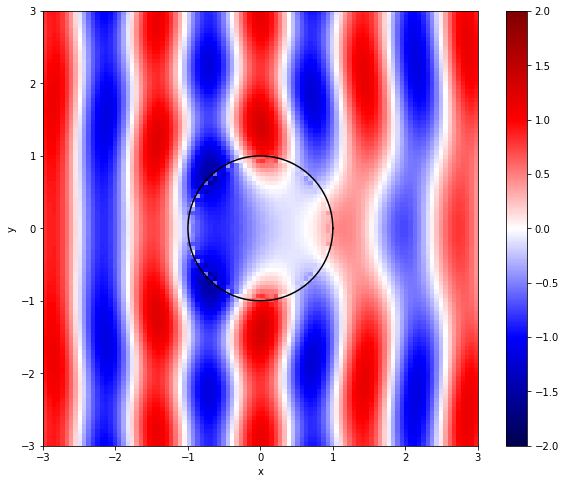

In [23]:
fig = plt.figure(figsize=(10, 8))
plt.imshow(np.real(total_field.T), extent=[xmin, xmax, ymin, ymax], clim=[-2,2], cmap='seismic')
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), 'k')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()